# BEM-BEM Coupling using a simple multitrace formulation

### Background

*This tutorial creates very large matrices and should only be run on sufficiently large workstations. For smaller computers please reduce the wavenumber k.*

In this notebook we demonstrate the solution of a Helmholtz transmission problem using a simple multitrace formulation.
The basic multitrace operator has the form
$$
A:=\begin{bmatrix}
-K & V\\
D  & K'\end{bmatrix},
$$
where $K$ is the double-layer, $V$ the single-layer, $K'$ the adjoint double-layer and $D$ the hypersingular boundary operator.

This multitrace operator has important properties. If $V:= [u, u_n]^T$ is the pair of Dirichlet/Neumann data of an interior Helmholtz solution then
$$
\left[\frac{1}{2}I + A\right]V = V.
$$
Similarly, if $V$ is the boundary data pair of an exterior radiating Helmholtz solution then
$$
\left[\frac{1}{2}I - A\right]V = V.
$$
Furthermore, from the above properties it follows that $(2A)^2 = I$. Hence, this operator is self-regularizing.

Now let $A_i$ be the multitrace operator for an interior Helmholtz problem with wavenumber $k_i$ and $A_e$ be the multitrace operator for an exterior Helmholtz problem with wavenumber $k_e$. Let $V^{inc}:= [u^{inc}, u_n^{inc}]$ be the boundary data of an incident wave (e.g. a plane wave). Then it follows from the properties of the multitrace operator that the associated Helmholtz transmission problem with exterior wavenumber $k_e$ and interior wavenumber $k_i$ has boundary data $V:=[u, u_n]^T$ described by
$$
\left[\frac{1}{2}I + A_i\right]V = \left[\frac{1}{2}I - A_e\right]V + V^{inc}
$$
giving
$$
(A_i + A_e)V = V^{inc}.
$$
To regularize this equation we just multiply with $(A_i + A_e)$ to obtain
$$
(A_i + A_e)^2 = (A_i + A_e)V^{inc}.
$$
More details can be found in *X. Claeys, R. Hiptmair, "Multi-Trace Boundary Integral Formulation for Acoustic Scattering by Composite Structures", 66 (2013), pp. 1163--1201*.

The implementation of multitrace operators requires care. If we want to use a typical dual space pairing of piecewise constant functions for the Neumann data and continuous, piecewise linear functions for the Dirichlet data we need to define the constant functions on the dual grid to ensure that both have the same number of unknowns and a stable dual-space pairing. BEM++ implements constant basis functions on dual grids. However, the computational effort grows significantly as a dual grid approach requires barycentrically refined grids that have six times as many elements as the original grid.

The following code automates all these steps. But because of the dual grid approach it requires the assembly of operators on quite large grids even though the original problem is relatively small.

### Implementation

We start with the ususal imports.

In [1]:
import bempp.api
import numpy as np

INFO:BEMPP:Dolfin could not be imported. FEM/BEM coupling with FEniCS not available.


The following defines the wavenumber and the grid. We use roughly 10 elements per wavelength. The wavenumber in the interior domain is $n * k$, where $n$ is a refractive index.

In [2]:
k = 10
n = .5
h = 2 * np.pi/(10 * k)
grid = bempp.api.shapes.ellipsoid(1.5, 1, 1, h=h)

We now define the Dirichlet and Neumann data of the incident wave.

In [3]:
def dirichlet_fun(x, n, domain_index, result):
    result[0] = np.exp(1j * k * x[0])

def neumann_fun(x, n, domain_index, result):
    result[0] = 1j * k * n[0] * np.exp(1j *k * x[0])
    

The following code defines the interior and exterior multitrace operators. In particular, the operator product is interesting. BEM++ handles all occuring mass matrices automatically. The assembly of a multitrace operator is efficient in the sense that only one single-layer and one double-layer operator need to be assembled. All others are derived from those two. The ``multitrace_operator`` method implements the correct spaces for the Dirichlet and Neumann data. To access these spaces we just access the spaces of the component operators.

In [4]:
Ai = bempp.api.operators.boundary.helmholtz.multitrace_operator(grid, n * k)
Ae = bempp.api.operators.boundary.helmholtz.multitrace_operator(grid, k)

op = (Ai + Ae)
op_squared = op * op

dirichlet_space = Ai[0, 0].domain
neumann_space = Ai[0, 1].domain

We need to discretize the incident field  into grid functions.

In [5]:
dirichlet_grid_fun = bempp.api.GridFunction(dirichlet_space, fun=dirichlet_fun)
neumann_grid_fun = bempp.api.GridFunction(neumann_space, fun=neumann_fun)

INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (5300,5300). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 3.69E-02 sec.
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (5300,5300). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.69E-02 sec.


The following discretizes the left-hand side operator and the right-hand side vector. The logging messages show that a large number of operators need to be created. These are mass matrix transformations to derive the various operators from a basic single-layer and a basic double-layer operator. Currently, the mass matrix operators and their possible inverses in terms of LU decompositions are not accumulated but stored separately. This will be improved in future versions of BEM++.

In [6]:
op_discrete = op.strong_form()
op_discrete_squared = op_discrete * op_discrete
rhs = op_discrete * np.concatenate([dirichlet_grid_fun.coefficients, neumann_grid_fun.coefficients])

INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (5300,5300). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 5.14E-02 sec.
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (5300,5300). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 5.04E-02 sec.
INFO:BEMPP:DLP. START ASSEMBLY. Dim: (5300,5300). Assembly Type: hmat
INFO:BEMPP:DLP. FINISHED ASSEMBLY. Time: 8.77E+00 sec. Mem Size (Mb): 4.13E+01. Compression: 9.62E-02
INFO:BEMPP:DLP. START ASSEMBLY. Dim: (5300,5300). Assembly Type: hmat
INFO:BEMPP:DLP. FINISHED ASSEMBLY. Time: 9.61E+00 sec. Mem Size (Mb): 5.26E+01. Compression: 1.23E-01
INFO:BEMPP:SLP. START ASSEMBLY. Dim: (31788,31788). Assembly Type: hmat
INFO:BEMPP:SLP. FINISHED ASSEMBLY. Time: 1.79E+01 sec. Mem Size (Mb): 3.54E+02. Compression: 2.30E-02
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (31788,5300). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 3.95E-02 sec.
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (31788,31788). Assembly Type

We can now solve the discretized linear system and recover the dirichlet and boundary data of the solution.

In [7]:
from scipy.sparse.linalg import gmres

it_count = 0
def iteration_counter(x):
    global it_count
    it_count += 1
    
x, info = gmres(op_discrete_squared, rhs, callback=iteration_counter)
print("The linear system was solved in {0} iterations".format(it_count))

# The following grid function stores the computed boundary data of the total field.
total_field_dirichlet = bempp.api.GridFunction(dirichlet_space, coefficients=x[:dirichlet_space.global_dof_count])
total_field_neumann = bempp.api.GridFunction(neumann_space, coefficients=x[dirichlet_space.global_dof_count:])

The linear system was solved in 50 iterations


We now generate the points for the plot of a slice of the solution in the $z=0$ plane.

In [8]:
Nx = 300
Ny = 300
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size)))
u_evaluated = np.zeros(points.shape[1], dtype=np.complex128)

x, y = points[:2]
idx_ext = np.sqrt((x/1.5)**2 + y**2) > 1.0
idx_int = np.sqrt((x/1.5)**2 + y**2) <= 1.0

points_exterior = points[:, idx_ext]
points_interior = points[:, idx_int]

To compute the solution in the interior and exterior of the sphere we need to assemble the corresponding potential operators and then compute the field data using Greens' representation formula.

In [9]:
slp_pot_int = bempp.api.operators.potential.helmholtz.single_layer(dirichlet_space, points_interior, n * k)
slp_pot_ext = bempp.api.operators.potential.helmholtz.single_layer(dirichlet_space, points_exterior, k)
dlp_pot_int = bempp.api.operators.potential.helmholtz.double_layer(dirichlet_space, points_interior, n * k)
dlp_pot_ext = bempp.api.operators.potential.helmholtz.double_layer(dirichlet_space, points_exterior, k)

total_field_int = (slp_pot_int * total_field_neumann - dlp_pot_int * total_field_dirichlet).ravel()
total_field_ext = (dlp_pot_ext * total_field_dirichlet - slp_pot_ext * total_field_neumann).ravel() + np.exp(
    1j *k * points_exterior[0])

total_field = np.zeros(points.shape[1], dtype='complex128')
total_field[idx_ext] = total_field_ext
total_field[idx_int] = total_field_int
total_field = total_field.reshape([Nx, Ny])


INFO:BEMPP:POTENTIAL OPERATOR ASSEMBLY START. Number of points: 11704. Space dimension: 5300. Assembly type: hmat 
INFO:BEMPP:FINISHED POTENTIAL OPERATOR ASSEMBLY. Time: 2.24E+00 sec.
INFO:BEMPP:POTENTIAL OPERATOR ASSEMBLY START. Number of points: 78296. Space dimension: 5300. Assembly type: hmat 
INFO:BEMPP:FINISHED POTENTIAL OPERATOR ASSEMBLY. Time: 1.40E+01 sec.
INFO:BEMPP:POTENTIAL OPERATOR ASSEMBLY START. Number of points: 11704. Space dimension: 5300. Assembly type: hmat 
INFO:BEMPP:FINISHED POTENTIAL OPERATOR ASSEMBLY. Time: 2.19E+00 sec.
INFO:BEMPP:POTENTIAL OPERATOR ASSEMBLY START. Number of points: 78296. Space dimension: 5300. Assembly type: hmat 
INFO:BEMPP:FINISHED POTENTIAL OPERATOR ASSEMBLY. Time: 1.49E+01 sec.


Finally, we can plot the solution of the scattering problem in the $z=0$ plane.

<matplotlib.colorbar.Colorbar instance at 0x7f30385916c8>

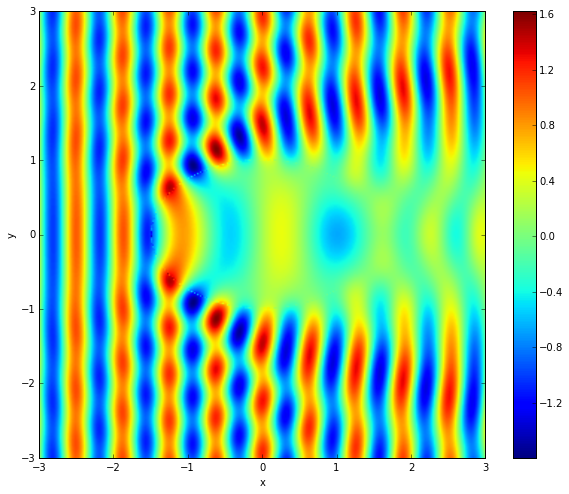

In [10]:
%matplotlib inline 
# Plot the image
from matplotlib import pyplot as plt
fig = plt.figure(figsize =(10, 8))
plt.imshow(np.real(total_field.T),extent=[-3, 3, -3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()